In [1]:
# from qiskit.circuit.random import random_circuit

# # Define the number of qubits and the number of gates (depth)
# num_qubits = 10
# depth = 100

# # Generate a random circuit
# qc = random_circuit(num_qubits=num_qubits, depth=depth, max_operands=4, measure=False)

# # Draw the circuit
# # random_qc.draw('mpl')

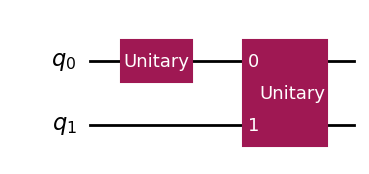

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import random_unitary

seed = 42

# Create a Quantum Circuit with 2 qubits
qc = QuantumCircuit(2)

# Apply random gate to first qubit
qc.unitary(random_unitary(2, seed=seed), [0])

# Apply random 2-qubit gate
qc.unitary(random_unitary(4, seed=seed), [0, 1])

# Draw the circuit
qc.draw('mpl')

In [3]:
class Gate:
    def __init__(self, qubits, unitary):
        self.qubits = qubits  # span of qubits on which the gate acts
        self.unitary = unitary  # unitary matrix representing the gate

    def __repr__(self):
        return f'Gate(qubits={self.qubits}, unitary=\n{self.unitary})'

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

# 0 1 2 ->  0 1 2
# 3 9 10 -> 0 1 2
# 8 3 1 -> 2 1 0
# 7 8 0 -> 1 2 0
# 6 7 5 -> 1 2 0
# 1 0   -> 1 0
def remap_qubits(qubits):
    sorted_unique = sorted(set(qubits))
    rank_dict = {num: rank for rank, num in enumerate(sorted_unique)}
    return [rank_dict[num] for num in qubits]


gates_list = []

n_qubits = qc.num_qubits

for instruction in qc.data:
    gate_operation = instruction.operation
    # qubits = [n_qubits - qubit._index - 1 for qubit in instruction.qubits]
    qubits = [qubit._index for qubit in instruction.qubits]
    
    single_gate_circuit = QuantumCircuit(len(qubits))
    single_gate_circuit.append(gate_operation, remap_qubits(qubits))
    unitary_matrix = Operator(single_gate_circuit).data

    gates_list.append(Gate(qubits, unitary_matrix))

for gate in gates_list:
    print(gate)
    print()

Gate(qubits=[0], unitary=
[[ 0.14398279-0.92188954j -0.05864249+0.35489392j]
 [ 0.35459797+0.06040626j  0.91839541+0.16480666j]])

Gate(qubits=[0, 1], unitary=
[[ 0.14480819+0.1752384j  -0.51892816-0.52424259j -0.14955858+0.312755j
   0.16913481-0.50538631j]
 [-0.92717439-0.08785062j -0.11260331-0.1818585j   0.12255872+0.09640286j
  -0.24498509-0.05045841j]
 [-0.00798428-0.20355071j -0.38932055-0.05180925j  0.26051706+0.32864025j
   0.44517308+0.65589332j]
 [ 0.03137922+0.19613952j  0.4980475 +0.08846049j  0.34078865+0.750661j
   0.01464807-0.15755843j]])



In [5]:
class TreeNode:
    def __init__(self, gate = None):
        self.left = None
        self.right = None
        self.span = None if gate is None else gate.qubits
        self.gate = gate

    def __repr__(self):
        return f'TreeNode(span={self.span}, left={self.left}, right={self.right})'

In [6]:
def build_tree(node_list):
    # iterate the list, when you find two consecutive gates having some qubits in common, create a new node with these gates as children and remove them from the list

    while len(node_list) > 1:
        for i in range(len(node_list) - 1):
            if node_list[i].span is None or node_list[i + 1].span is None:
                continue

            if len(set(node_list[i].span).intersection(node_list[i + 1].span)) > 0:
                new_node = TreeNode()
                new_node.left  = node_list[i ]
                new_node.right = node_list[i + 1]
                new_node.span = list(set(node_list[i].span).union(node_list[i + 1].span))
                node_list[i] = new_node
                node_list.pop(i + 1)
                break

    return node_list[0]

In [7]:
import time

start_time = time.time()

node_list = [TreeNode(gate) for gate in gates_list]
root = build_tree(node_list)

end_time = time.time()
contraction_time = end_time - start_time

print(root)
print(len(node_list))
print(f"Contraction time: {contraction_time} seconds")

TreeNode(span=[0, 1], left=TreeNode(span=[0], left=None, right=None), right=TreeNode(span=[0, 1], left=None, right=None))
1
Contraction time: 0.00010919570922851562 seconds


In [8]:
# create four sqlite tables: gates, qubits, circuit, circuit_gates and a db
import sqlite3

db_filename = 'data/quantum_circuit.db'

# remove the db
import os
try:
    os.remove(db_filename)
except FileNotFoundError:
    pass

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect(db_filename)
c = conn.cursor()

# Create additional tables
c.execute('''CREATE TABLE IF NOT EXISTS contractions (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                program_id INTEGER NOT NULL,
                span TEXT NOT NULL,
                left_id INTEGER DEFAULT NULL,
                right_id INTEGER DEFAULT NULL,
                kind TEXT NOT NULL,
                gate_id INTEGER DEFAULT NULL,
                FOREIGN KEY (program_id) REFERENCES programs (id),
                FOREIGN KEY (left_id) REFERENCES contractions (id),
                FOREIGN KEY (right_id) REFERENCES contractions (id),
                CHECK( ( kind = 'C' AND left_id IS NOT NULL AND right_id IS NOT NULL AND gate_id IS NULL ) 
                       OR ( kind = 'G' AND left_id IS NULL AND right_id IS NULL AND gate_id IS NOT NULL ) )
            )''')

c.execute('''CREATE TABLE IF NOT EXISTS experiments (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                program_id INTEGER NOT NULL,
                input_vector BLOB NOT NULL,
                output_vector BLOB NOT NULL,
                FOREIGN KEY (program_id) REFERENCES programs (id)
            )''')

c.execute('''CREATE TABLE IF NOT EXISTS gates (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                rank INTEGER NOT NULL,
                data BLOB NOT NULL
            )''')

c.execute('''CREATE TABLE IF NOT EXISTS programs (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                filename TEXT NOT NULL,
                contraction_cpu_time_us INTEGER DEFAULT NULL,
                tree_building_time_us INTEGER DEFAULT NULL
            )''')

# insert a program into the db
filename = 'test.qasm'
text = "NULL"
contraction_cpu_time_us = int(contraction_time * 1e6)

c.execute('''INSERT INTO programs (filename, contraction_cpu_time_us) VALUES (?, ?)''', (filename, contraction_cpu_time_us))

# insert the tree into the db
def insert_tree(node):
    if node.span is None:
        return

    if node.left is None and node.right is None:
        kind = 'G'
        # add gate to the gates table
        c.execute('''INSERT INTO gates (rank, data) VALUES (?, ?)''', (len(node.gate.qubits), node.gate.unitary.tobytes()))
        gate_id = c.lastrowid
        min_span = min(node.span)
        max_span = max(node.span)
        node_span_str = f'[{min_span}, {max_span}]'
        c.execute('''INSERT INTO contractions (program_id, span, kind, gate_id) VALUES (?, ?, ?, ?)''', (1, node_span_str, kind, gate_id))
    else:
        kind = 'C'
        left_id = insert_tree(node.left)
        right_id = insert_tree(node.right)
        c.execute('''INSERT INTO contractions (program_id, span, kind, left_id, right_id) VALUES (?, ?, ?, ?, ?)''', (1, str(node.span), kind, left_id, right_id))

    return c.lastrowid

insert_tree(root)

# Commit changes and close the connection
conn.commit()
conn.close()


In [9]:
import numpy as np
import time
from qiskit_aer import Aer
from qiskit.quantum_info import random_statevector

# Generate a random state vector
input_state = random_statevector(2**qc.num_qubits, seed=seed)

# Set up the backend
backend = Aer.get_backend('statevector_simulator')

qc_init = QuantumCircuit(qc.num_qubits)

# Initialize the input state
qc_init.initialize(input_state.data, range(qc.num_qubits))

# Combine the initialization circuit with the original circuit
qc_init.compose(qc, inplace=True)

# Execute the circuit
start_time = time.time()
result = backend.run(qc_init).result()
end_time = time.time()

# Get the output state vector
output_state = result.get_statevector(qc_init)

result_referece = np.asarray(output_state, np.complex128)

# Calculate the time taken
execution_time = end_time - start_time

print(f"Input state: {input_state}")
print(f"Output state: {output_state}")
print(f"Execution time: {execution_time} seconds")

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect(db_filename)
c = conn.cursor()

# insert an experiment into the db
input_vector  = np.asarray(input_state,  np.complex128).data.tobytes()
output_vector = np.asarray(output_state, np.complex128).data.tobytes()

c.execute('''INSERT INTO experiments (program_id, input_vector, output_vector) VALUES (?, ?, ?)''', (1, input_vector, output_vector))

# Commit changes and close the connection
conn.commit()
conn.close()

Input state: Statevector([ 0.10614794-0.67964147j, -0.36227759-0.45361314j,
              0.26141904+0.0445331j ,  0.32764493-0.11016284j],
            dims=(2, 2))
Output state: Statevector([-0.20807198+0.18276721j,  0.18440946+0.40531767j,
              0.2305648 +0.64038383j,  0.13961856-0.49220729j],
            dims=(2, 2))
Execution time: 0.0009388923645019531 seconds


In [10]:
from qiskit.quantum_info import Operator

# Get the unitary matrix of the quantum circuit
unitary_matrix = Operator(qc).data

print("Unitary matrix of the circuit:")
print(unitary_matrix)

Unitary matrix of the circuit:
[[ 0.030057  -0.3255077j  -0.46086552-0.52586967j  0.35729506+0.01391567j
   0.13639931-0.50768809j]
 [-0.24342923+0.7708148j   0.01210659-0.50947256j  0.02269592-0.13179633j
  -0.25807724-0.04887391j]
 [-0.32372354-0.06383603j -0.27630458-0.10264085j  0.45871739+0.06662027j
   0.16883953+0.74892055j]
 [ 0.3566001 +0.06076563j  0.37137678+0.16295744j  0.75580591-0.26107229j
  -0.24697032-0.06536364j]]


In [11]:
import numpy as np

result_dot = np.dot(unitary_matrix, input_state.data)

print("Output state vector obtained by multiplying the unitary matrix with the input state vector:")
print(result_dot)

print("Reference output state vector:")
print(result_referece)

Output state vector obtained by multiplying the unitary matrix with the input state vector:
[-0.20807198+0.18276721j  0.18440946+0.40531767j  0.2305648 +0.64038383j
  0.13961856-0.49220729j]
Reference output state vector:
[-0.20807198+0.18276721j  0.18440946+0.40531767j  0.2305648 +0.64038383j
  0.13961856-0.49220729j]
